# Example of variational quantum eigensolver

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

from tools import Circuit, gate_dic
from state_vector_qpu import State, StateVectorQPU


In [2]:
from copy import deepcopy

def compute_energy(H, res):
    """computing <psi|H|psi>
    
    Args:
        H (list): list [(lambda_i, P_i)] with P_i = list [(X, 0), (Y, 1), ...]
        psi (State): final state of circuit
        
    Returns:
        <psi|H|psi>
    """
    val = 0.0
    for coeff, term in H:
        res_copy = deepcopy(res)
        for pauli, qb in term:
            res_copy.apply(gate_dic[pauli], [qb])
        val += coeff * res.to_vec().conj().dot(res_copy.to_vec())
        
    return val
 
# test on Bell state
circ = Circuit(2, [("H", [0]), ("CNOT", [0, 1])])

qpu = StateVectorQPU(2, gate_dic)
res = qpu.submit(circ)

print(res)

H = [(1., [("Z", 0), ("Z", 1)])] # ZZ measurement
energy = compute_energy(H, res)
print("<ZZ> =", energy)

H = [(1., [("Z", 0)])] # Z measurement

type(res)
energy = compute_energy(H, res)
print("<Z> =", energy)

|00> : (0.7071067811865475+0j) 
|01> : 0j 
|10> : 0j 
|11> : (0.7071067811865475+0j) 

<ZZ> = (0.9999999999999998+0j)
<Z> = (-2.2371143170757382e-17+0j)


In [3]:
# "hardware-efficient ansatz"
def make_ansatz(theta):
    n_layers = 3
    n_qbits = len(theta) // n_layers
    gate_list = []
    for ind in range(n_layers):
        for qb in range(n_qbits):
            gate_list.append(("RY", [qb], theta[ind*n_qbits+ qb]))
        for qb in range(n_qbits-1):
            gate_list.append(("CNOT", [qb, qb+1]))
    circ = Circuit(n_qbits, gate_list)
    return circ

    
def get_energy(theta):
    global energy_list
    n_layers = 3
    n_qbits = len(theta) // n_layers
    qpu = StateVectorQPU(n_qbits, gate_dic)
    circ = make_ansatz(theta)
    res = qpu.submit(circ)
    energy = compute_energy(H, res)
    
    # keeping track of values encountered during optimization
    energy_list.append(energy)
    return energy

def get_gradient(theta):
    grad = []
    for k in range(len(theta)):
        e_plus_pi_h = get_energy([t+np.pi/2 if ind==k else t for ind, t in enumerate(theta)])
        e_minus_pi_h = get_energy([t-np.pi/2 if ind==k else t for ind, t in enumerate(theta)])
        grad.append(0.5*(e_plus_pi_h-e_minus_pi_h))
    
    return grad
# test on Heisenberg model

n_sites = 3
H = [(1, [("Z", i), ("Z", (i+1)%n_sites)]) for i in range(n_sites)]
H += [(1, [("X", i), ("X", (i+1)%n_sites)]) for i in range(n_sites)]
H += [(1, [("Y", i), ("Y", (i+1)%n_sites)]) for i in range(n_sites)]

# simple test
theta = np.random.rand(n_sites*3)
energy_list = []
en = get_energy(theta)

# now do optimization
from scipy.optimize import minimize
energy_list = []

result = minimize(get_energy, x0 = theta, method="CG")
print(result)

/usr/local/lib64/python3.9/site-packages/scipy/optimize/_numdiff.py:598: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/usr/local/lib64/python3.9/site-packages/scipy/optimize/_linesearch.py:155: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -2.9999999999648246
       x: [-2.547e+00  1.232e+00  1.030e+00 -6.262e-01  1.591e+00
            1.987e+00 -4.908e+00  2.555e+00  4.241e+00]
     nit: 16
     jac: [-2.593e-06 -1.371e-06  3.368e-06 -2.950e-06 -8.047e-07
            6.557e-07  1.967e-06 -3.070e-06  1.848e-06]
    nfev: 310
    njev: 31


### Optimization trace

/usr/local/lib64/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


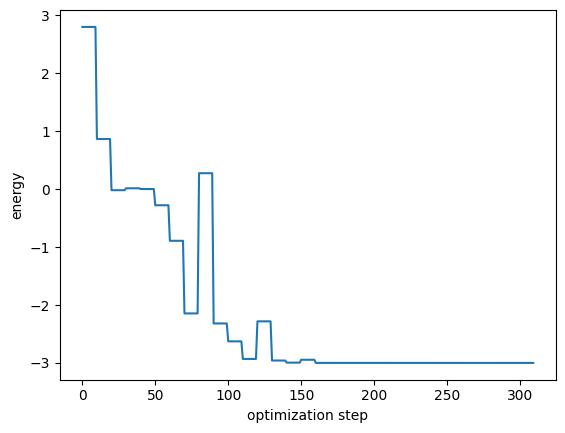

In [4]:
import matplotlib.pyplot as plt
plt.plot(energy_list)
plt.ylabel("energy")
plt.xlabel("optimization step");

## With an explicit gradient

In [5]:
# now do optimization
from scipy.optimize import minimize
energy_list = []

result = minimize(get_energy, x0 = theta, method="CG", jac=get_gradient)
print(result)

/usr/local/lib64/python3.9/site-packages/scipy/optimize/_differentiable_functions.py:243: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -2.9999999999998033
       x: [-2.54736592+0.j  1.23213139+0.j  1.02976419+0.j -0.62618694+0.j
            1.59072729+0.j  1.98738837+0.j -4.90844877+0.j  2.55525942+0.j
            4.2407496 +0.j]
     nit: 16
     jac: [-5.19779825e-07+0.j  4.84655322e-07+0.j  3.45432167e-07+0.j
           -2.80413552e-07+0.j -2.12546301e-07+0.j  1.75338812e-07+0.j
           -7.83252237e-07+0.j -3.49943255e-07+0.j  2.77165189e-07+0.j]
    nfev: 31
    njev: 31


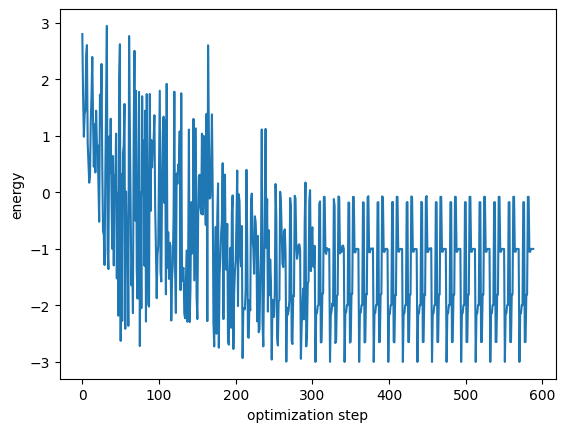

In [6]:
import matplotlib.pyplot as plt
plt.plot(energy_list)
plt.ylabel("energy")
plt.xlabel("optimization step");

Warning: here, the trace contains all the values of energy evaluations, including those used for computing the gradient (hence the jagged shape).